# Part 3: Object Detection 7-10

# Importing the Libraries


In [1]:
! pip install torch torchvision albumentations tqdm

In [5]:
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import yaml
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm.notebook import tqdm
import matplotlib.patches as patches
import time

import warnings
warnings.filterwarnings("ignore")

# Loading the data.yaml File

In [6]:
# Load data.yaml
with open("/kaggle/input/road-sign-detection-dataset/Road_Sign_Detection  3/data.yaml", "r") as stream:
    data_config = yaml.safe_load(stream)


num_classes = data_config['nc']
class_names = data_config['names']

print(f"Number of Classes: {num_classes}")
print(f"Class Names: {class_names}")

Number of Classes: 25
Class Names: ['-Road narrows on right', 'Attention Please-', 'Beware of children', 'CYCLE ROUTE AHEAD WARNING', 'Crosswalk', 'Dangerous Left Curve Ahead', 'Dangerous Rright Curve Ahead', 'No Entry', 'No_Over_Taking', 'One way road', 'Speed bump ahead', 'Speed limit', 'Speed limit 100 Kph', 'Speed limit 120 Kph', 'Speed limit 20 Kph', 'Speed limit 30 Kph', 'Speed limit 40 Kph', 'Speed limit 50 Kph', 'Speed limit 60 Kph', 'Speed limit 70 Kph', 'Speed limit 80 Kph', 'Speed limit 90 Kph', 'Stop_Sign', 'Uneven Road', 'roundabout']


#  Creating a Class for Loading the DataSet in Proper Format 

In [7]:
class RoadSignDataset(Dataset):
    def __init__(self, root_dir, yaml_file, mode='train', transform=None):
        """
        Args:
            root_dir (str): Root directory containing the data
            yaml_file (str): Path to data.yaml file|
            mode (str): 'train', 'valid', or 'test'
            transform: Optional transform to be applied
        """
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        
        # Load yaml file
        with open(yaml_file, 'r') as f:
            self.yaml_data = yaml.safe_load(f)
            
        self.num_classes = len(self.yaml_data['names'])
        self.class_names = self.yaml_data['names']
        
        # Set up paths based on mode
        self.img_dir = os.path.join(root_dir, mode, 'images')
        self.label_dir = os.path.join(root_dir, mode, 'labels')
        
        # Get all image files
        self.img_files = [f for f in os.listdir(self.img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
        
        if len(self.img_files) == 0:
            raise ValueError(f"No images found in {self.img_dir}")
            
        print(f"Found {len(self.img_files)} images in {mode} set")
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Load labels
        label_path = os.path.join(self.label_dir, img_name.replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt'))
        boxes = []
        labels = []
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    class_id, x_center, y_center, width, height = map(float, line.strip().split())
                    # Convert YOLO format to [x_min, y_min, x_max, y_max]
                    x_min = (x_center - width/2)
                    y_min = (y_center - height/2)
                    x_max = (x_center + width/2)
                    y_max = (y_center + height/2)
                    boxes.append([x_min, y_min, x_max, y_max])
                    labels.append(int(class_id))
        
        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return image, target

# Q7 Fucntion for Image Augmentation and Data tranformaion Step

In [8]:
def get_transform(train=True):
    """Define transformations for training and validation/testing"""
    transforms_list = []
    transforms_list.append(transforms.ToTensor())
    
    if train:
        transforms_list.extend([
            transforms.RandomHorizontalFlip(0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1))
        ])
    
    return transforms.Compose(transforms_list)


def collate_fn(batch):
    """Custom collate function for the DataLoader"""
    return tuple(zip(*batch))

# DataLoader Setup along with using the above transformar fucntion

In [ ]:
 # Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
# Define base path
base_path = '/kaggle/input/road-sign-detection-dataset/Road_Sign_Detection  3'
yaml_path = os.path.join(base_path, 'data.yaml')
    
# Initialize datasets with correct paths
train_dataset = RoadSignDataset(base_path, yaml_path, mode='train', transform=get_transform(train=True))
valid_dataset = RoadSignDataset(base_path, yaml_path, mode='valid', transform=get_transform(train=False))
test_dataset = RoadSignDataset(base_path, yaml_path, mode='test', transform=get_transform(train=False))
    
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

# Q8 Plotting the Random Images of train, valid, test 

Plotting training samples:


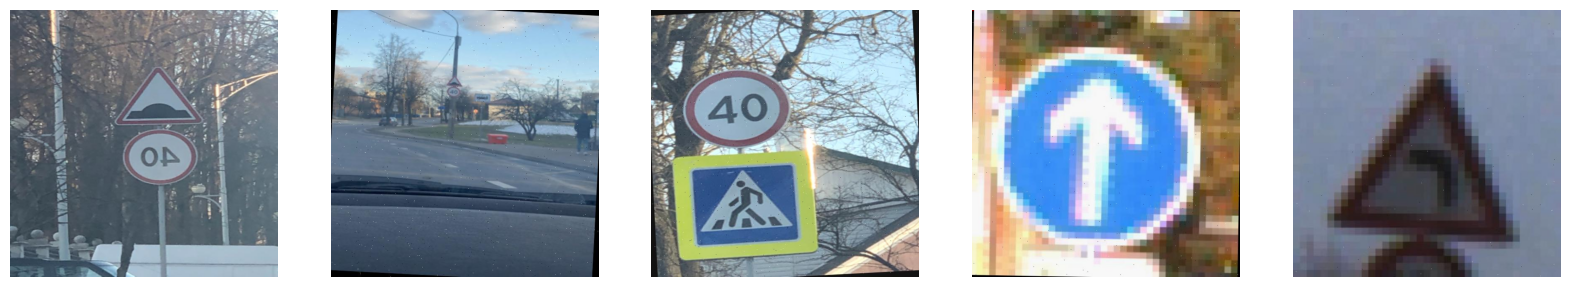

Plotting validation samples:


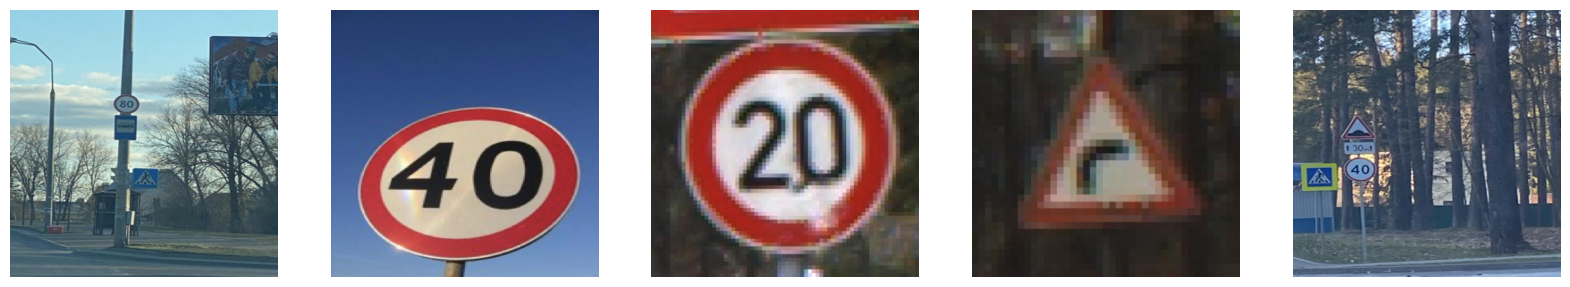

Plotting test samples:


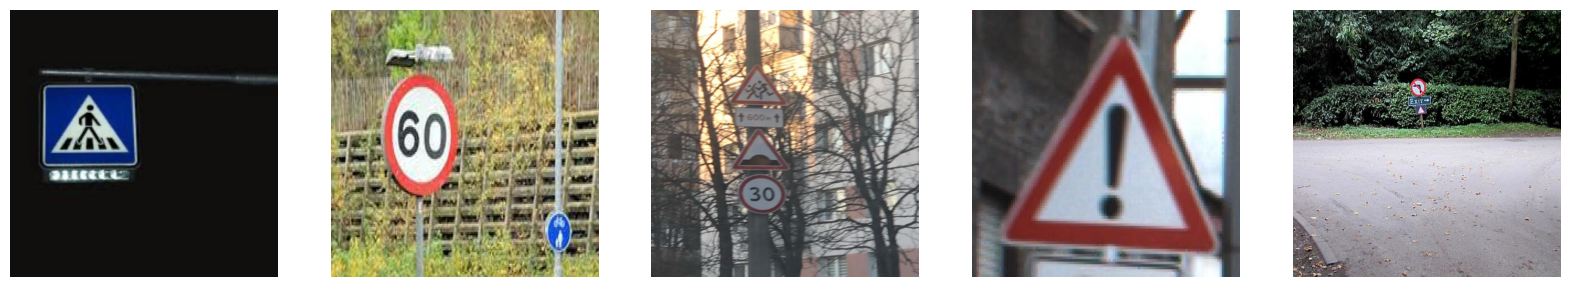

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_samples(dataset, num_samples=5):
    """Plot random samples from the dataset"""
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    
    for i in range(num_samples):
        idx = np.random.randint(len(dataset))
        img, target = dataset[idx]
        
        # Convert tensor to numpy for plotting
        img_np = img.permute(1, 2, 0).numpy()
        
        axes[i].imshow(img_np)
        
        if 'boxes' in target:
            for box in target['boxes']:
                x_min, y_min, x_max, y_max = box.numpy()
                width = x_max - x_min
                height = y_max - y_min
                rect = plt.Rectangle((x_min, y_min), width, height,
                                  fill=False, color='red')
                axes[i].add_patch(rect)
        
        axes[i].axis('off')
    
    plt.show()

# Plot sample images
print("Plotting training samples:")
plot_samples(train_dataset)
print("Plotting validation samples:")
plot_samples(valid_dataset)
print("Plotting test samples:")
plot_samples(test_dataset)    

# Q9 Implementing Object Detection Model from Scratch (FAST_RCNN)

In [10]:
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method 
    #and hence need to work per the way the model class is defined
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

# Training of the model

In [12]:
# Initialize model
model = fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = train_dataset.num_classes + 1  # +1 for background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# Train model
print("Starting training pipeline...")
print(f"Device being used: {device}")
print(f"Number of classes: {train_dataset.num_classes}")
print("\nDataset sizes:")
print(f"Training: {len(train_dataset)} images")
print(f"Validation: {len(valid_dataset)} images")
print(f"Test: {len(test_dataset)} images")

n_epochs = 30
best_valid_loss = float("inf")
patience = 8  # Number of epochs to wait for improvement
patience_counter = 0

for epoch in range(n_epochs):
    _n = len(train_loader)

    for ix, inputs in enumerate(train_loader):

        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
                [losses[k] for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        pos = (epoch + (ix + 1) / _n)
        
            # Print training loss details
    print(f"Epoch {epoch + 1}/{n_epochs}, "
                  f"Loss: {loss.item():.4f}, "
                  f"Loc Loss: {loc_loss.item():.4f}, "
                  f"Regr Loss: {regr_loss.item():.4f}, "
                  f"Objectness Loss: {loss_objectness.item():.4f}, "
                  f"RPN Box Reg Loss: {loss_rpn_box_reg.item():.4f}", end='\n')
        


    _n = len(valid_loader)
    for ix, inputs in enumerate(valid_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        pos = (epoch + (ix + 1) / _n)

    # Save the best model
    if loss < best_valid_loss:
        best_valid_loss = loss
        torch.save(model.state_dict(), "tut2-model.pt")
        patience_counter = 0  # Reset the patience counter if validation loss improves
    else:
        patience_counter += 1

        # Print validation loss details
    print(f'Epoch {epoch + 1}/{n_epochs}, '
              f"Val Loss: {loss.item():.4f}, "
              f"Val Loc Loss: {loc_loss.item():.4f}, "
              f"Val Regr Loss: {regr_loss.item():.4f}, "
              f"Val Objectness Loss: {loss_objectness.item():.4f}, "
              f"Val RPN Box Reg Loss: {loss_rpn_box_reg.item():.4f}", end='\n')

    if patience_counter >= patience:
        print("\nEarly stopping triggered")
        break


# Saving the weights of the model
torch.save( model.state_dict(), 'final_model.pth')

Starting training pipeline...
Device being used: cuda
Number of classes: 25

Dataset sizes:
Training: 5303 images
Validation: 621 images
Test: 308 images
Epoch 1/30, Loss: 0.1942, Loc Loss: 0.1174, Regr Loss: 0.0458, Objectness Loss: 0.0248, RPN Box Reg Loss: 0.0062
Epoch 1/30, Val Loss: 0.3064, Val Loc Loss: 0.1810, Val Regr Loss: 0.0903, Val Objectness Loss: 0.0282, Val RPN Box Reg Loss: 0.0068
Epoch 2/30, Loss: 0.2428, Loc Loss: 0.1353, Regr Loss: 0.0889, Objectness Loss: 0.0154, RPN Box Reg Loss: 0.0032
Epoch 2/30, Val Loss: 0.3305, Val Loc Loss: 0.1938, Val Regr Loss: 0.0826, Val Objectness Loss: 0.0467, Val RPN Box Reg Loss: 0.0073
Epoch 3/30, Loss: 0.0908, Loc Loss: 0.0467, Regr Loss: 0.0394, Objectness Loss: 0.0008, RPN Box Reg Loss: 0.0038
Epoch 3/30, Val Loss: 0.1796, Val Loc Loss: 0.0762, Val Regr Loss: 0.0360, Val Objectness Loss: 0.0563, Val RPN Box Reg Loss: 0.0112
Epoch 4/30, Loss: 0.2524, Loc Loss: 0.1340, Regr Loss: 0.0987, Objectness Loss: 0.0170, RPN Box Reg Loss: 0.

<All keys matched successfully>

# Q10 Computing IoU and Printing Predictions on test images

In [12]:
def calculate_iou(box1, box2, normalize=True, image_size=(640, 640)):
    try:
        box1 = np.array(box1, dtype=np.float32)
        box2 = np.array(box2, dtype=np.float32)
        
        # Check if boxes need normalization/denormalization
        box1_normalized = np.all(box1 <= 1.0)
        box2_normalized = np.all(box2 <= 1.0)
        
        # Convert both boxes to the same scale
        if normalize:
            # Convert to normalized coordinates (0-1)
            if not box1_normalized:
                box1 = box1 / np.array([image_size[0], image_size[1], image_size[0], image_size[1]])
            if not box2_normalized:
                box2 = box2 / np.array([image_size[0], image_size[1], image_size[0], image_size[1]])
        else:
            # Convert to absolute coordinates
            if box1_normalized:
                box1 = box1 * np.array([image_size[0], image_size[1], image_size[0], image_size[1]])
            if box2_normalized:
                box2 = box2 * np.array([image_size[0], image_size[1], image_size[0], image_size[1]])
        
        
        # Calculate intersection
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])
        
        intersection = max(0, x2 - x1) * max(0, y2 - y1)
        box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
        box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
        union = box1_area + box2_area - intersection
        
        iou = intersection / union if union > 0 else 0
        return float(iou)
    except Exception as e:
        print(f"Error calculating IoU: {e}")
        return 0.0

In [13]:
def evaluate_test_set(model, test_loader, device='cuda', class_names=None):
    """
    Evaluate model on test set and create results CSV and bbox coordinate files
    Args:
        model: The model to evaluate
        test_loader: DataLoader containing images and targets
        device: Device to run evaluation on
        class_names: Dictionary mapping class indices to class names
    """
    if class_names is None:
        class_names = {
            0: 'Road narrows on right',
            1: 'Attention Please',
            2: 'Beware of children',
            3: 'CYCLE ROUTE AHEAD WARNING',
            4: 'Crosswalk',
            5: 'Dangerous Left Curve Ahead',
            6: 'Dangerous Right Curve Ahead',
            7: 'No Entry',
            8: 'No Over Taking',
            9: 'One way road',
            10: 'Speed bump ahead',
            11: 'Speed limit',
            12: 'Speed limit 100 Kph',
            13: 'Speed limit 120 Kph',
            14: 'Speed limit 20 Kph',
            15: 'Speed limit 30 Kph',
            16: 'Speed limit 40 Kph',
            17: 'Speed limit 50 Kph',
            18: 'Speed limit 60 Kph',
            19: 'Speed limit 70 Kph',
            20: 'Speed limit 80 Kph',
            21: 'Speed limit 90 Kph',
            22: 'Stop Sign',
            23: 'Uneven Road',
            24: 'roundabout'
        }
    
    model.eval()
    results = []
    bbox_records = []
    
    def get_class_name(label):
        """Helper function to safely get class name from label"""
        label_idx = int(label)
        return class_names.get(label_idx, f"Unknown_{label_idx}")
    
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(test_loader):
            images = [img.to(device) for img in images]
            predictions = model(images)
            
            for i, (prediction, target) in enumerate(zip(predictions, targets)):
                pred_boxes = prediction['boxes'].cpu().numpy()
                pred_scores = prediction['scores'].cpu().numpy()
                pred_labels = prediction['labels'].cpu().numpy()
                
                # Get ground truth boxes and labels
                gt_boxes = target['boxes'].cpu().numpy()
                gt_labels = target['labels'].cpu().numpy()
                
                # Generate unique image ID using batch index and image index
                img_name = os.path.splitext(test_loader.dataset.img_files[batch_idx * test_loader.batch_size + i])[0]
                img_id = f"{img_name}"
                
                if len(pred_boxes) > 0 and len(gt_boxes) > 0:
                    # Calculate IoU for each prediction-ground truth pair
                    max_iou = 0
                    best_pred_idx = 0
                    best_gt_idx = 0
                    
                    for p_idx, pred_box in enumerate(pred_boxes):
                        for g_idx, gt_box in enumerate(gt_boxes):
                            current_iou = calculate_iou(pred_box, gt_box)
                            if current_iou > max_iou:
                                max_iou = current_iou
                                best_pred_idx = p_idx
                                best_gt_idx = g_idx
                    
                    # Get class names for prediction and ground truth
                    pred_class = get_class_name(pred_labels[best_pred_idx])
                    gt_class = get_class_name(gt_labels[best_gt_idx])
                    
                    # Store results with maximum IoU prediction
                    results.append({
                        'image_id': img_id,
                        'predicted_class': pred_class,
                        'iou_score': float(max_iou),
                    })
                    
                    # Store bbox coordinates
                    bbox_records.append({
                        'image_id': img_id,
                        'predicted_box': pred_boxes[best_pred_idx].tolist(),
                        'actual_box': gt_boxes[best_gt_idx].tolist(),
                        'confidence': float(pred_scores[best_pred_idx]),
                        'predicted_class': pred_class,
                        'actual_class': gt_class,
                        'iou_score': float(max_iou)
                    })
                else:
                    # Handle cases with no predictions or no ground truth
                    pred_class = get_class_name(pred_labels[0]) if len(pred_labels) > 0 else "No Prediction"
                    gt_class = get_class_name(gt_labels[0]) if len(gt_labels) > 0 else "No Ground Truth"
                    
                    results.append({
                        'image_id': img_id,
                        'actual_class': gt_class,
                        'iou_score': 0.0,
                    })
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    results_df.to_csv('detection_results.csv', index=False)
   
    # Calculate statistics
    average_iou = results_df['iou_score'].mean()
    print(f"\nEvaluation Summary:")
    print(f"Total images processed: {len(results_df)}")
    print(f"Average IoU: {average_iou:.4f}")
    print(f"Max IoU: {results_df['iou_score'].max():.4f}")
    print(f"Min IoU: {results_df['iou_score'].min():.4f}")
    
    # Save bbox coordinates
    df_bbox = pd.DataFrame(bbox_records)
    df_bbox.to_csv('bbox_coordinates.csv', index=False)
        
    return results_df

In [88]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = train_dataset.num_classes + 1  # +1 for background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model = model.to(device)

model.load_state_dict(torch.load('/kaggle/working/final_model.pth'))

# saving the required csv file 
results_df = evaluate_test_set(model, test_loader, device=device)


Evaluation Summary:
Total images processed: 622
Average IoU: 0.7489
Max IoU: 0.9869
Min IoU: 0.0000


The model IoU: 0.7489

Visualizing clean predictions on test set:


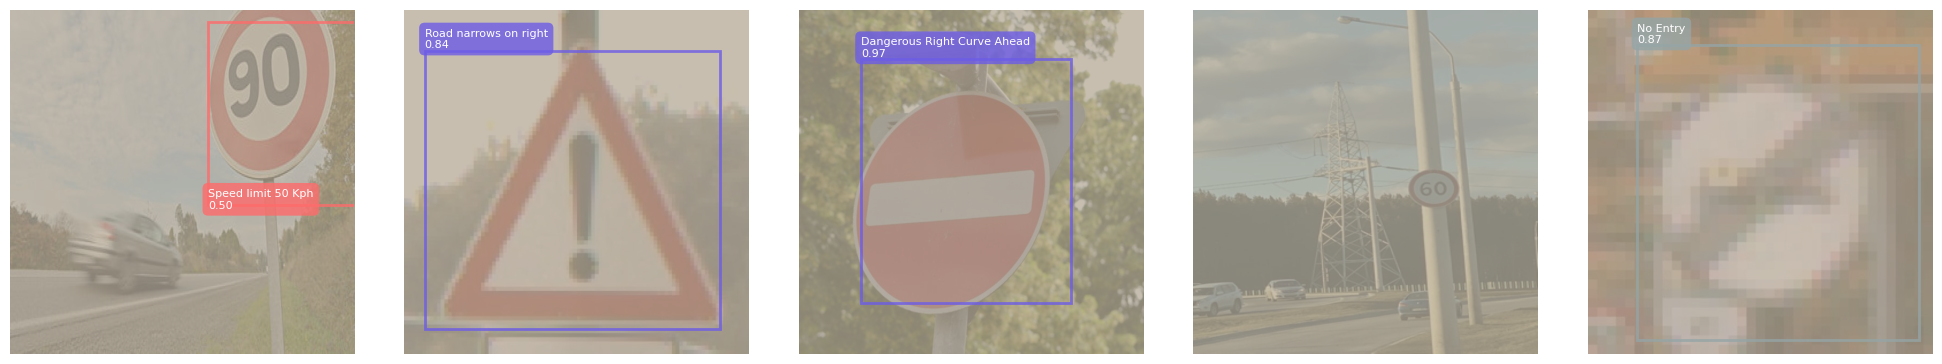

In [107]:
def visualize_clean_predictions(model, dataset, class_names, num_samples=5, device='cuda', confidence_threshold=0.5):
    model.eval()
    
    # Create a figure with adequate size and spacing
    fig = plt.figure(figsize=(20, 4))
    fig.patch.set_facecolor('white')
    
    # Custom colors for different sign types
    color_map = {
        'Speed limit': '#FF6B6B',    # Red tone
        'Stop': '#4ECDC4',           # Teal
        'Warning': '#FFD93D',        # Yellow
        'No': '#95A5A6',            # Grey
        'Crosswalk': '#2ECC71',      # Green
        'default': '#6C5CE7'         # Purple
    }
    
    # Select random samples
    random_indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for idx, sample_idx in enumerate(random_indices):
        # Create subplot
        ax = plt.subplot(1, num_samples, idx + 1)
        ax.set_facecolor('white')
        
        # Get image
        image, _ = dataset[sample_idx]
        image = image.unsqueeze(0).to(device)
        
        # Get predictions
        with torch.no_grad():
            predictions = model(image)
            pred = predictions[0]
        
        # Convert image for display
        image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
        image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)
        
        # Display image with slight brightness adjustment for better visibility
        plt.imshow(image * 1.1)
        
        # Get predictions above threshold
        keep = pred['scores'].cpu().numpy() > confidence_threshold
        boxes = pred['boxes'].cpu().numpy()[keep]
        scores = pred['scores'].cpu().numpy()[keep]
        labels = pred['labels'].cpu().numpy()[keep]
        
        # Draw predictions
        for box, score, label in zip(boxes, scores, labels):
            pred_label = class_names[label - 1]
            
            # Determine box color based on sign type
            color = next((v for k, v in color_map.items() if k in pred_label), color_map['default'])
            
            # Draw box with rounded corners
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            
            # Create rectangle patch with alpha for semi-transparency
            rect = plt.Rectangle((x1, y1), width, height,
                               fill=False, 
                               linewidth=2,
                               edgecolor=color,
                               alpha=0.8)
            ax.add_patch(rect)
            
            # Create text box with prediction info
            text = f'{pred_label}\n{score:.2f}'
            text_box = ax.text(x1, y1 - 5, text,
                             fontsize=8,
                             color='white',
                             bbox=dict(
                                 facecolor=color,
                                 edgecolor='none',
                                 alpha=0.8,
                                 pad=3,
                                 boxstyle='round,pad=0.5'
                             ))
            
            # Adjust text box position if too close to top
            if y1 < 30:
                text_box.set_y(y2 + 5)
        
        # Remove axes for cleaner look
        ax.axis('off')
        
        # Add subtle border around the image
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
        for spine in ax.spines.values():
            spine.set_color('#dddddd')
            spine.set_linewidth(1)
    
    # Adjust layout
    plt.tight_layout(pad=2.0)
    plt.show()
    return fig

# Example usage:
print("Visualizing clean predictions on test set:")
fig = visualize_clean_predictions(model, test_dataset, class_names)